In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
df_train = pd.read_csv('../data/custom/df_train.csv')
df_train['DATETIME'] = pd.to_datetime(df_train['DATETIME'])


df_train["avg_temp"] = df_train[["temp_london","temp_bath","temp_liverpool"]].mean(axis=1)
df_train["avg_humidity"] = df_train[["humidity_london","humidity_bath","humidity_liverpool"]].mean(axis=1)

df_train_prophet = df_train[["DATETIME","ND_TARGET","avg_temp","avg_humidity"]]

# Splitting the data
split_index = int(len(df_train_prophet) * 0.8)
train = df_train_prophet.iloc[:split_index]
test = df_train_prophet.iloc[split_index:]

# Prophet

In [4]:
#Format Data for Prophet

train_prophet = train.reset_index() \
    .rename(columns={'DATETIME':'ds',
                     'ND_TARGET':'y'})

test_prophet = test.reset_index() \
    .rename(columns={'DATETIME':'ds',
                     'ND_TARGET':'y'})

### Baseline Prophet

In [15]:
#Fit Prophet Model

model = Prophet(changepoint_prior_scale=0.001)
model.add_country_holidays(country_name='UK')
model.fit(train_prophet)


13:55:47 - cmdstanpy - INFO - Chain [1] start processing
13:55:56 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
#Prediction

test_pred = model.predict(test_prophet)

Text(0.5, 1.0, 'First Day of November 2023 Forecast vs Actuals')

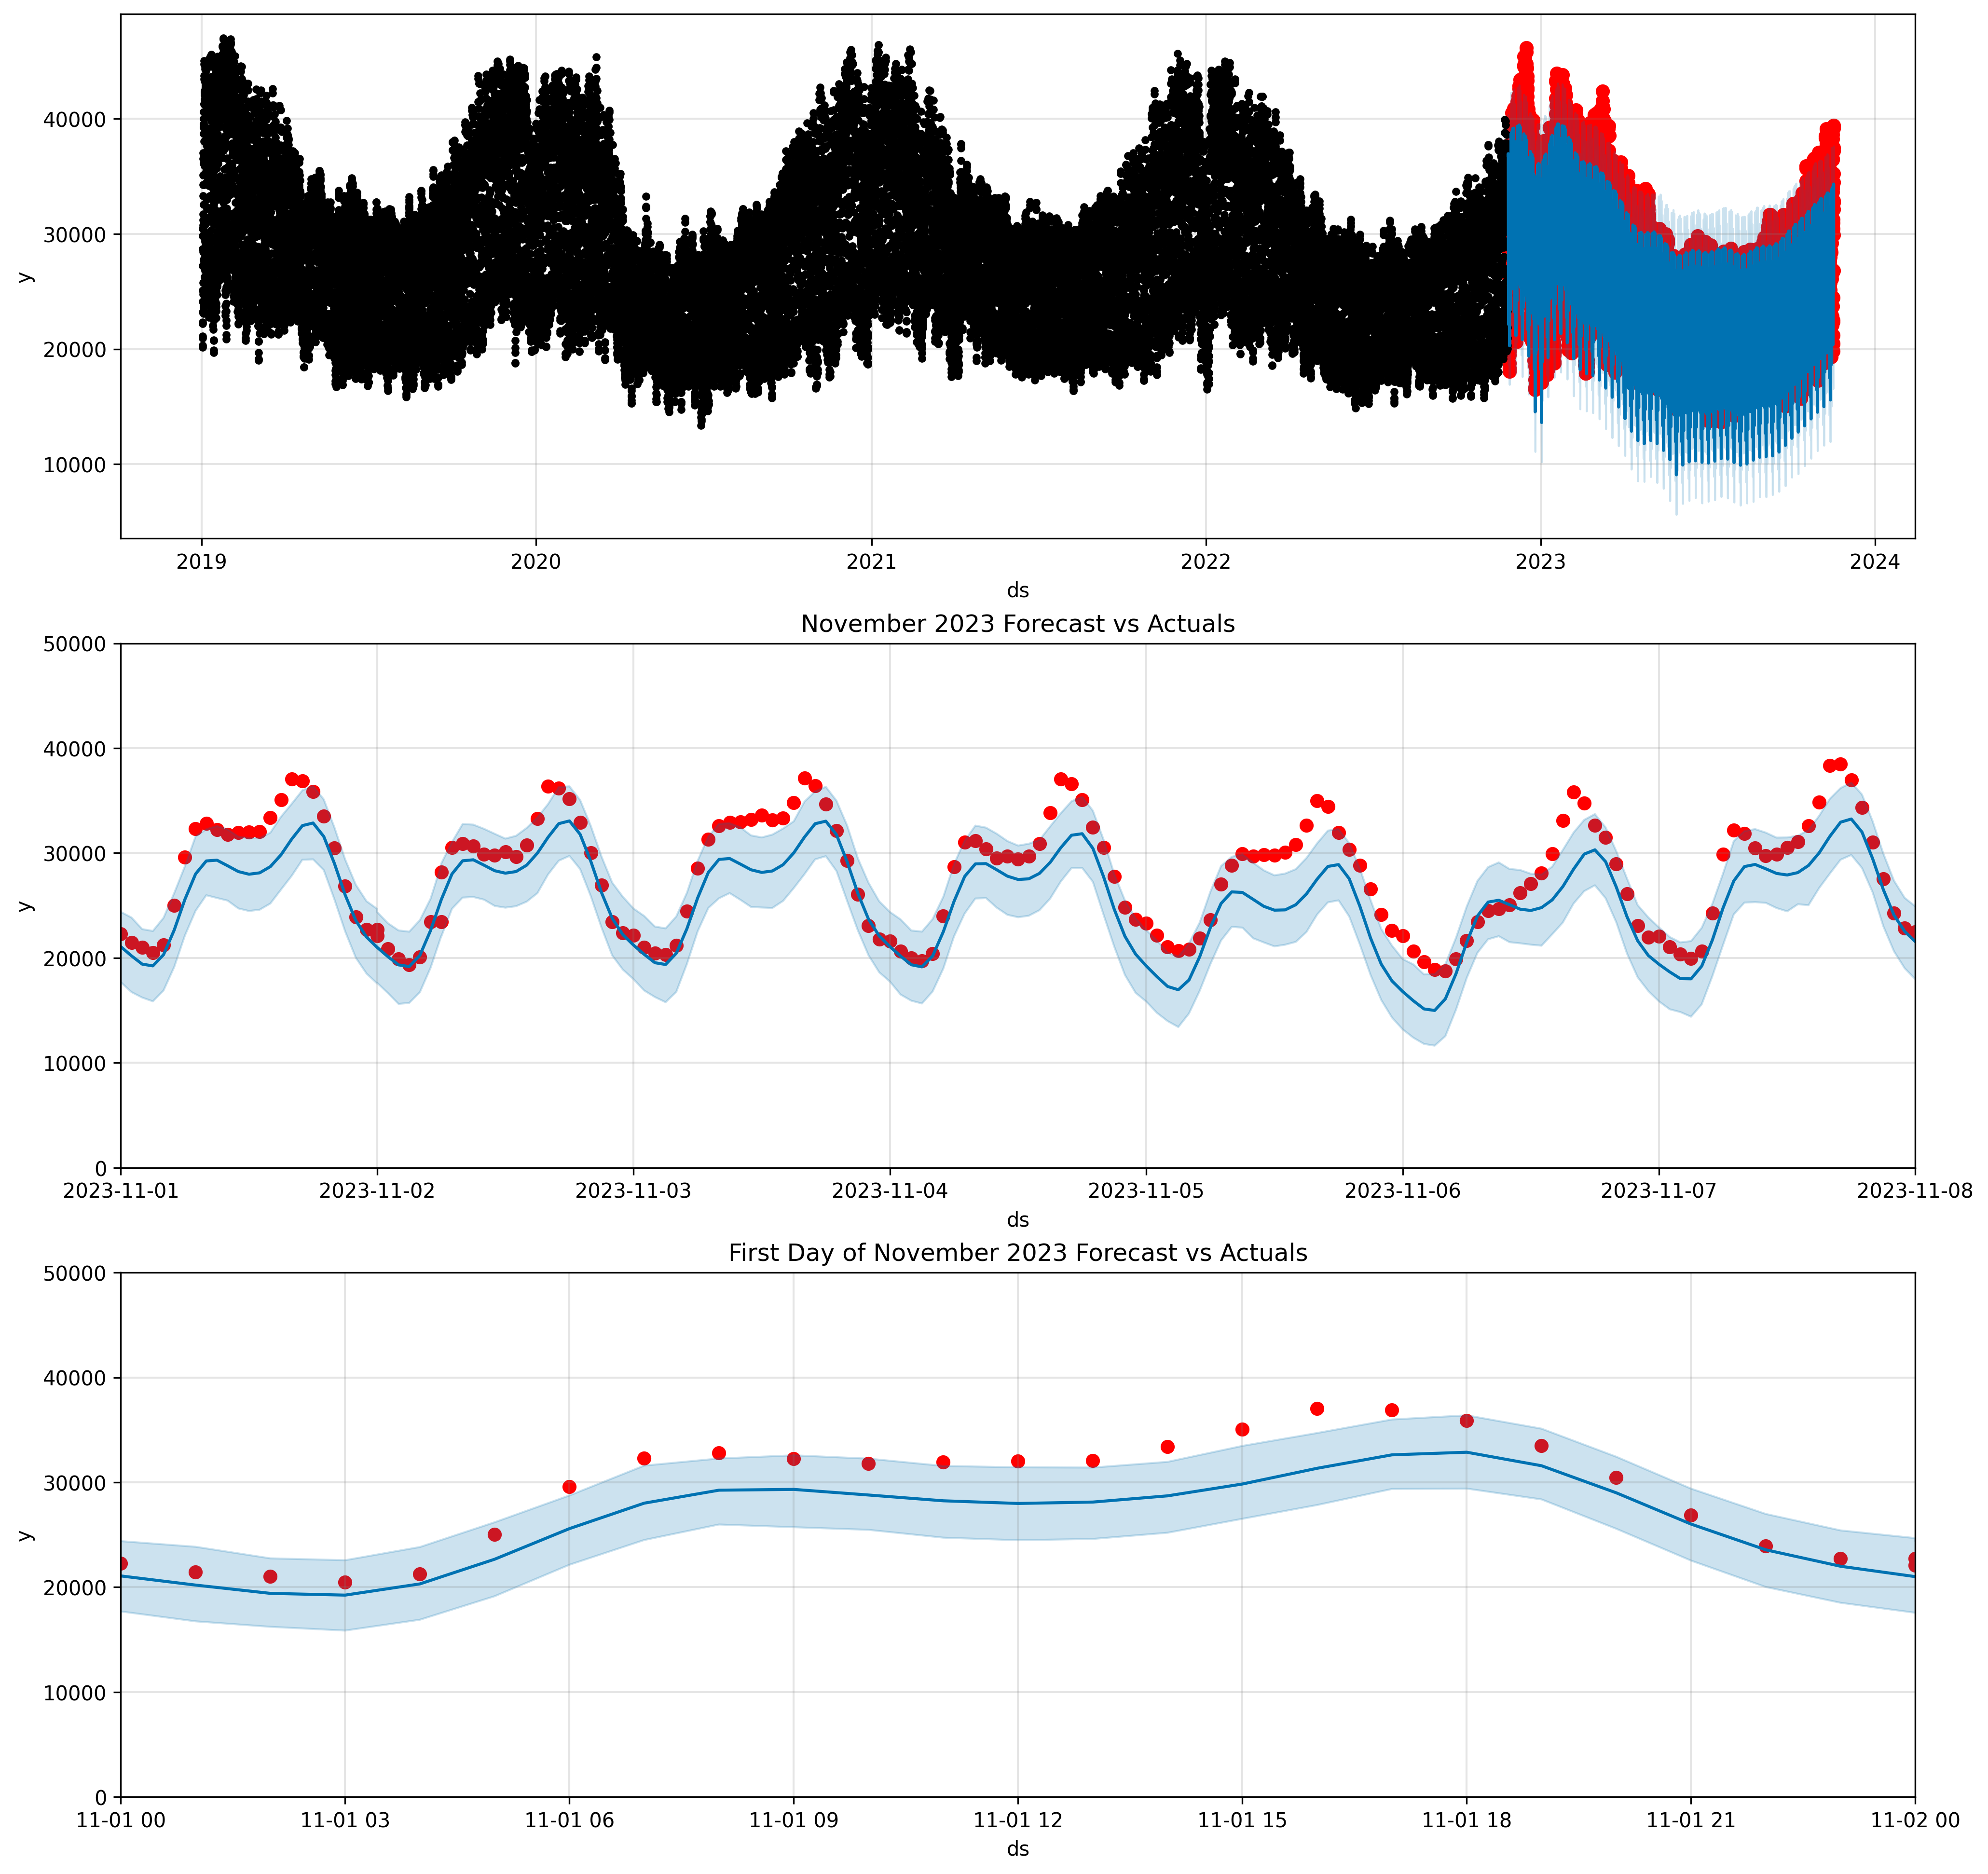

In [20]:
fig, axs = plt.subplots(3,1, figsize = (16,16), dpi = 300)

axs[0].scatter(test["DATETIME"], test['ND_TARGET'], color='r')
fig = model.plot(test_pred, ax=axs[0])

axs[1].scatter(test["DATETIME"], test['ND_TARGET'], color='r')
fig = model.plot(test_pred, ax=axs[1])
axs[1].set_xbound(lower=pd.to_datetime('2023-11-01'), upper=pd.to_datetime('2023-11-08'))
axs[1].set_ylim(0, 50000)
axs[1].set_title('November 2023 Forecast vs Actuals')

axs[2].scatter(test["DATETIME"], test['ND_TARGET'], color='r')
fig = model.plot(test_pred, ax=axs[2])
axs[2].set_xbound(lower=pd.to_datetime('2023-11-01'), upper=pd.to_datetime('2023-11-02'))
axs[2].set_ylim(0, 50000)
axs[2].set_title('First Day of November 2023 Forecast vs Actuals')

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test["ND_TARGET"], test_pred["yhat"])
r2 = r2_score(test["ND_TARGET"], test_pred["yhat"])
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 9446274.736323593
R2 Score: 0.7430788143071095


# Multivariate Prophet


In [9]:
#Fit model 

model1 = Prophet(changepoint_prior_scale=0.001)
model1.add_country_holidays(country_name='UK') 
model1.add_regressor("avg_temp")
model1.add_regressor("avg_humidity")
model1.fit(train_prophet)

13:39:02 - cmdstanpy - INFO - Chain [1] start processing
13:39:14 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
test_pred1 = model1.predict(test_prophet)

Text(0.5, 1.0, 'First Day of November 2023 Forecast vs Actuals')

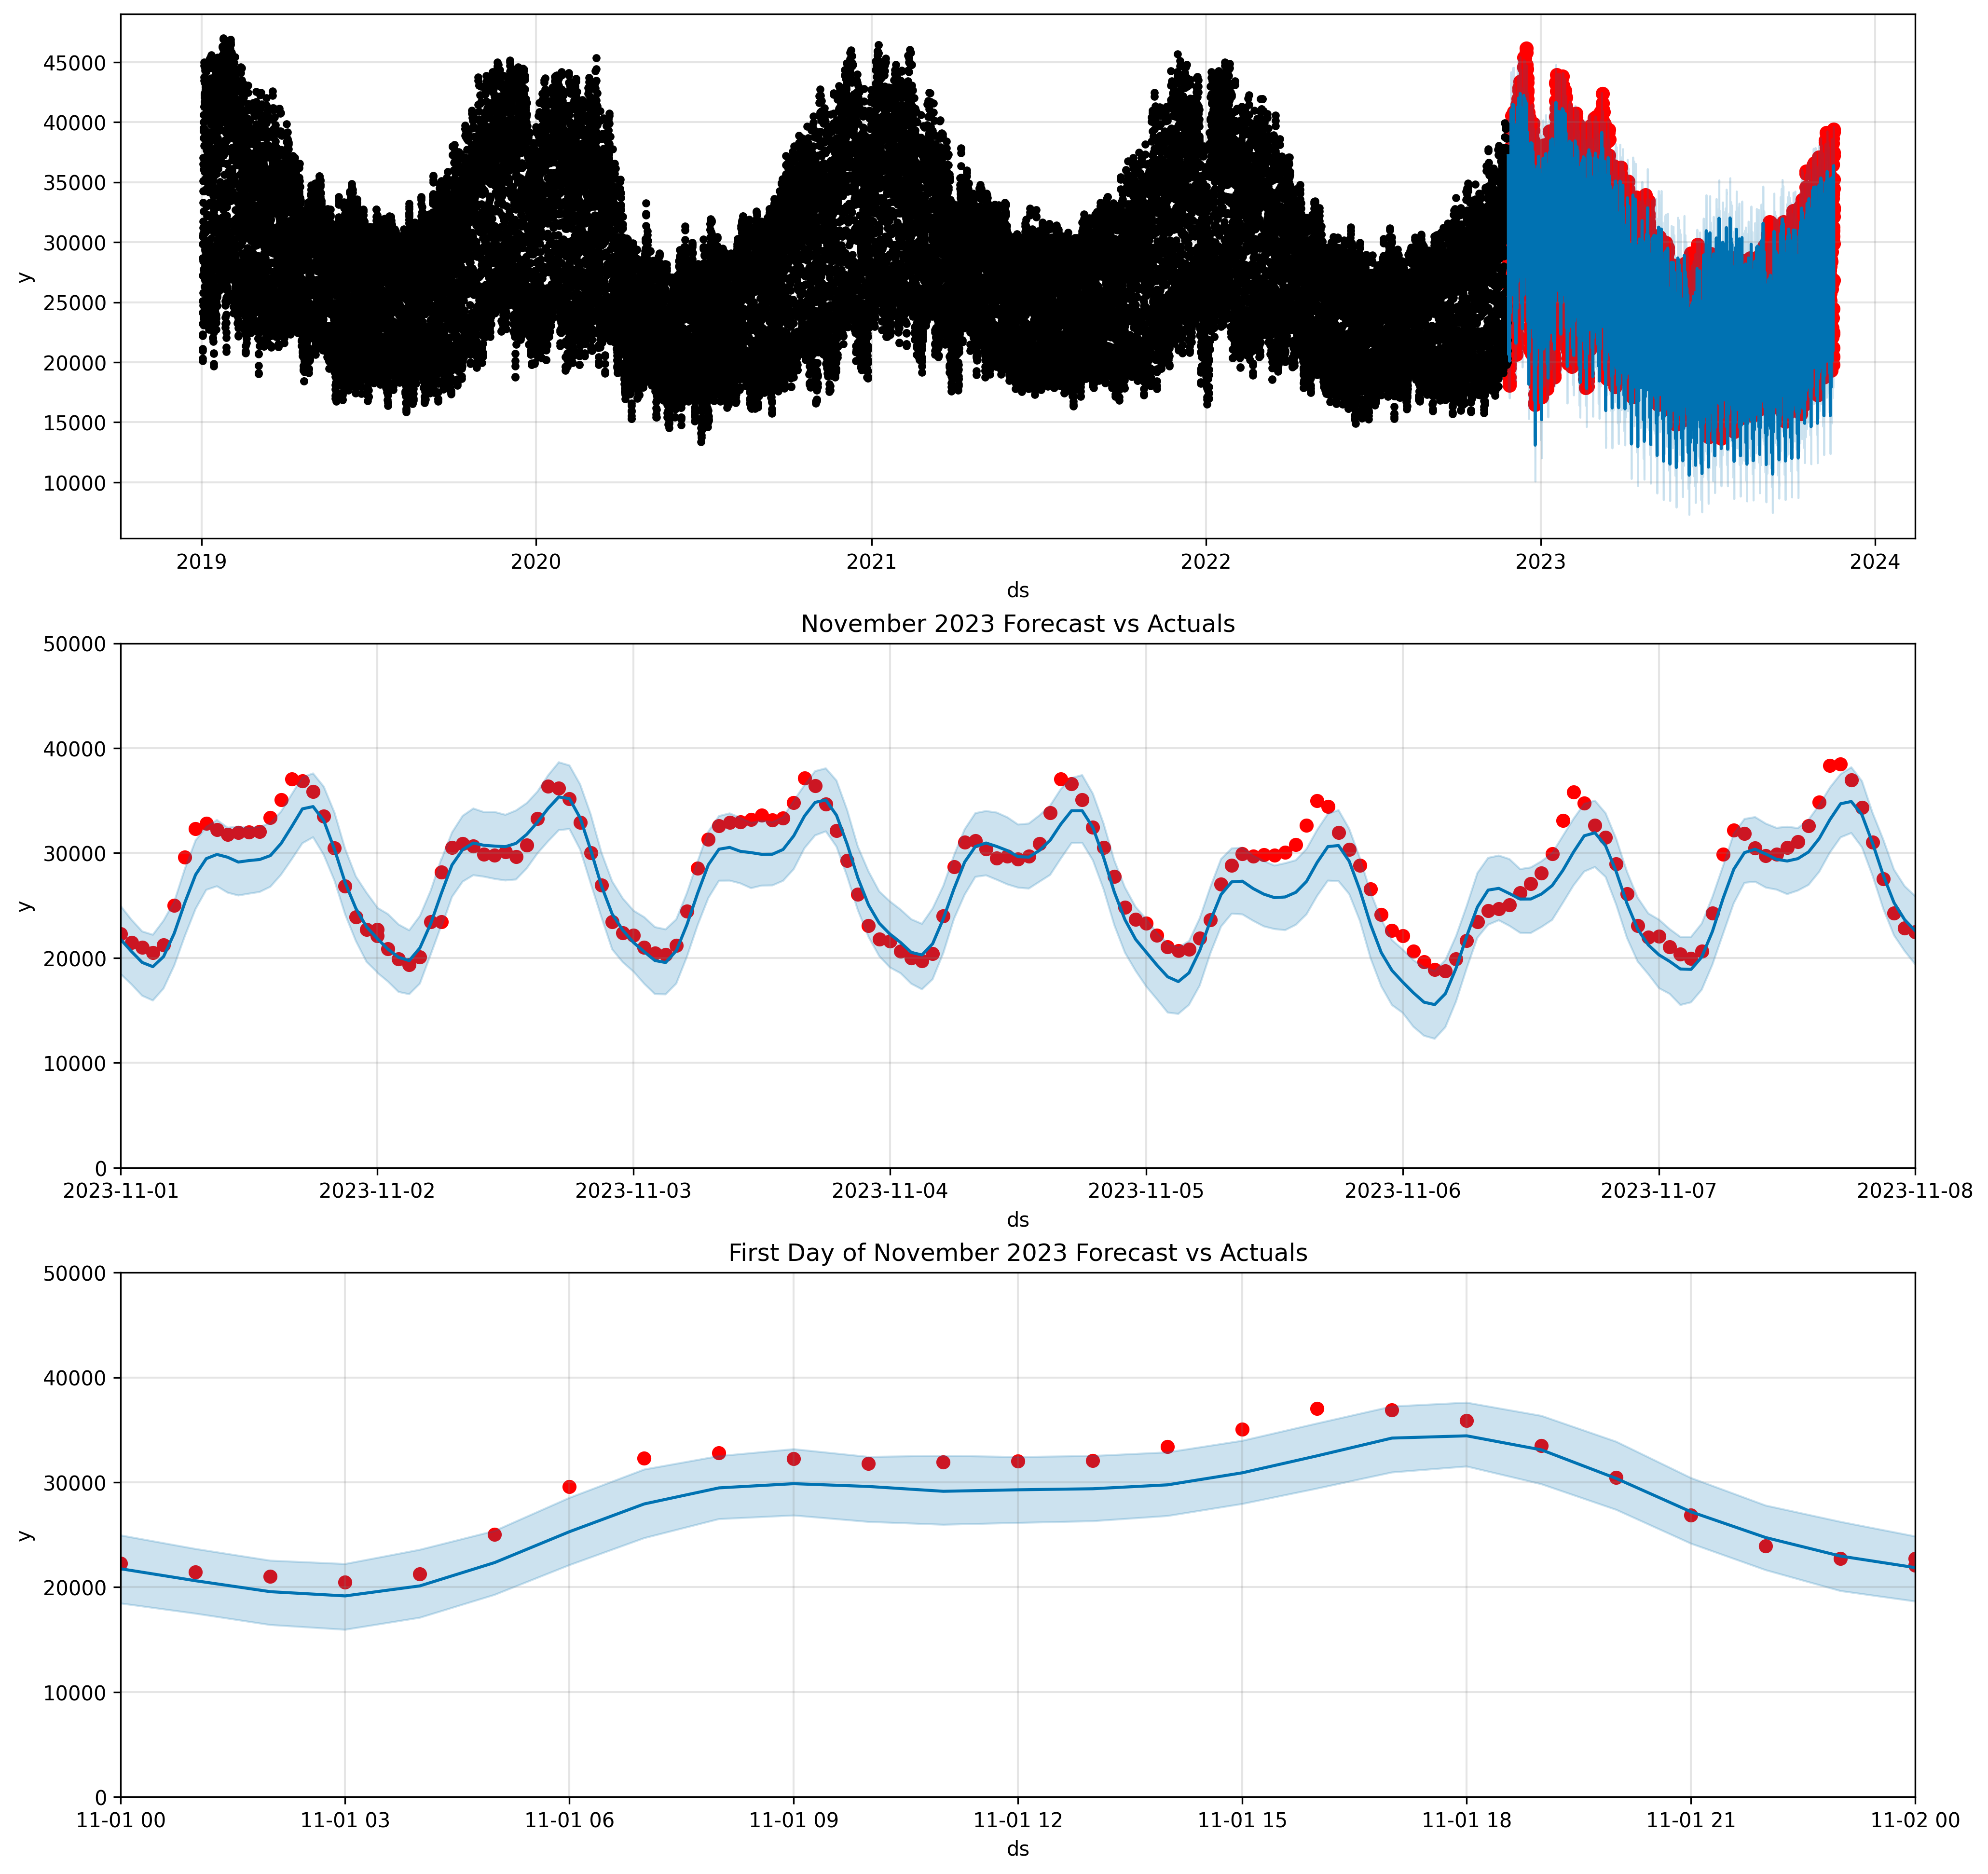

In [11]:
fig, axs = plt.subplots(3,1, figsize = (16,16), dpi = 300)

axs[0].scatter(test["DATETIME"], test['ND_TARGET'], color='r')
fig = model1.plot(test_pred1, ax=axs[0])

axs[1].scatter(test["DATETIME"], test['ND_TARGET'], color='r')
fig = model1.plot(test_pred1, ax=axs[1])
axs[1].set_xbound(lower=pd.to_datetime('2023-11-01'), upper=pd.to_datetime('2023-11-08'))
axs[1].set_ylim(0, 50000)
axs[1].set_title('November 2023 Forecast vs Actuals')

axs[2].scatter(test["DATETIME"], test['ND_TARGET'], color='r')
fig = model1.plot(test_pred1, ax=axs[2])
axs[2].set_xbound(lower=pd.to_datetime('2023-11-01'), upper=pd.to_datetime('2023-11-02'))
axs[2].set_ylim(0, 50000)
axs[2].set_title('First Day of November 2023 Forecast vs Actuals')


In [12]:
mse = mean_squared_error(test["ND_TARGET"], test_pred1["yhat"])
r2 = r2_score(test["ND_TARGET"], test_pred1["yhat"])
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 6725486.817470508
R2 Score: 0.8170792089222128


In [14]:
from prophet.serialize import model_to_json, model_from_json

with open('../models/models_sav/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model1))  # Save model

## Prophet Forecast

### 1. Univariate

In [23]:
total_prophet = pd.concat([train_prophet,test_prophet], axis=0)

modelpred = Prophet(changepoint_prior_scale=0.001)
modelpred.add_country_holidays(country_name='UK') 
#modelpred.add_regressor("avg_temp")
#modelpred.add_regressor("avg_humidity")
modelpred.fit(total_prophet)

14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:12:12 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future = modelpred.make_future_dataframe(periods=24*7, freq="H")
forecast = modelpred.predict(future)

future.tail()

,ds
42877,2023-11-23 18:00:00
42878,2023-11-23 19:00:00
42879,2023-11-23 20:00:00
42880,2023-11-23 21:00:00
42881,2023-11-23 22:00:00


Text(0.5, 1.0, 'November 2023 weekly forecast')

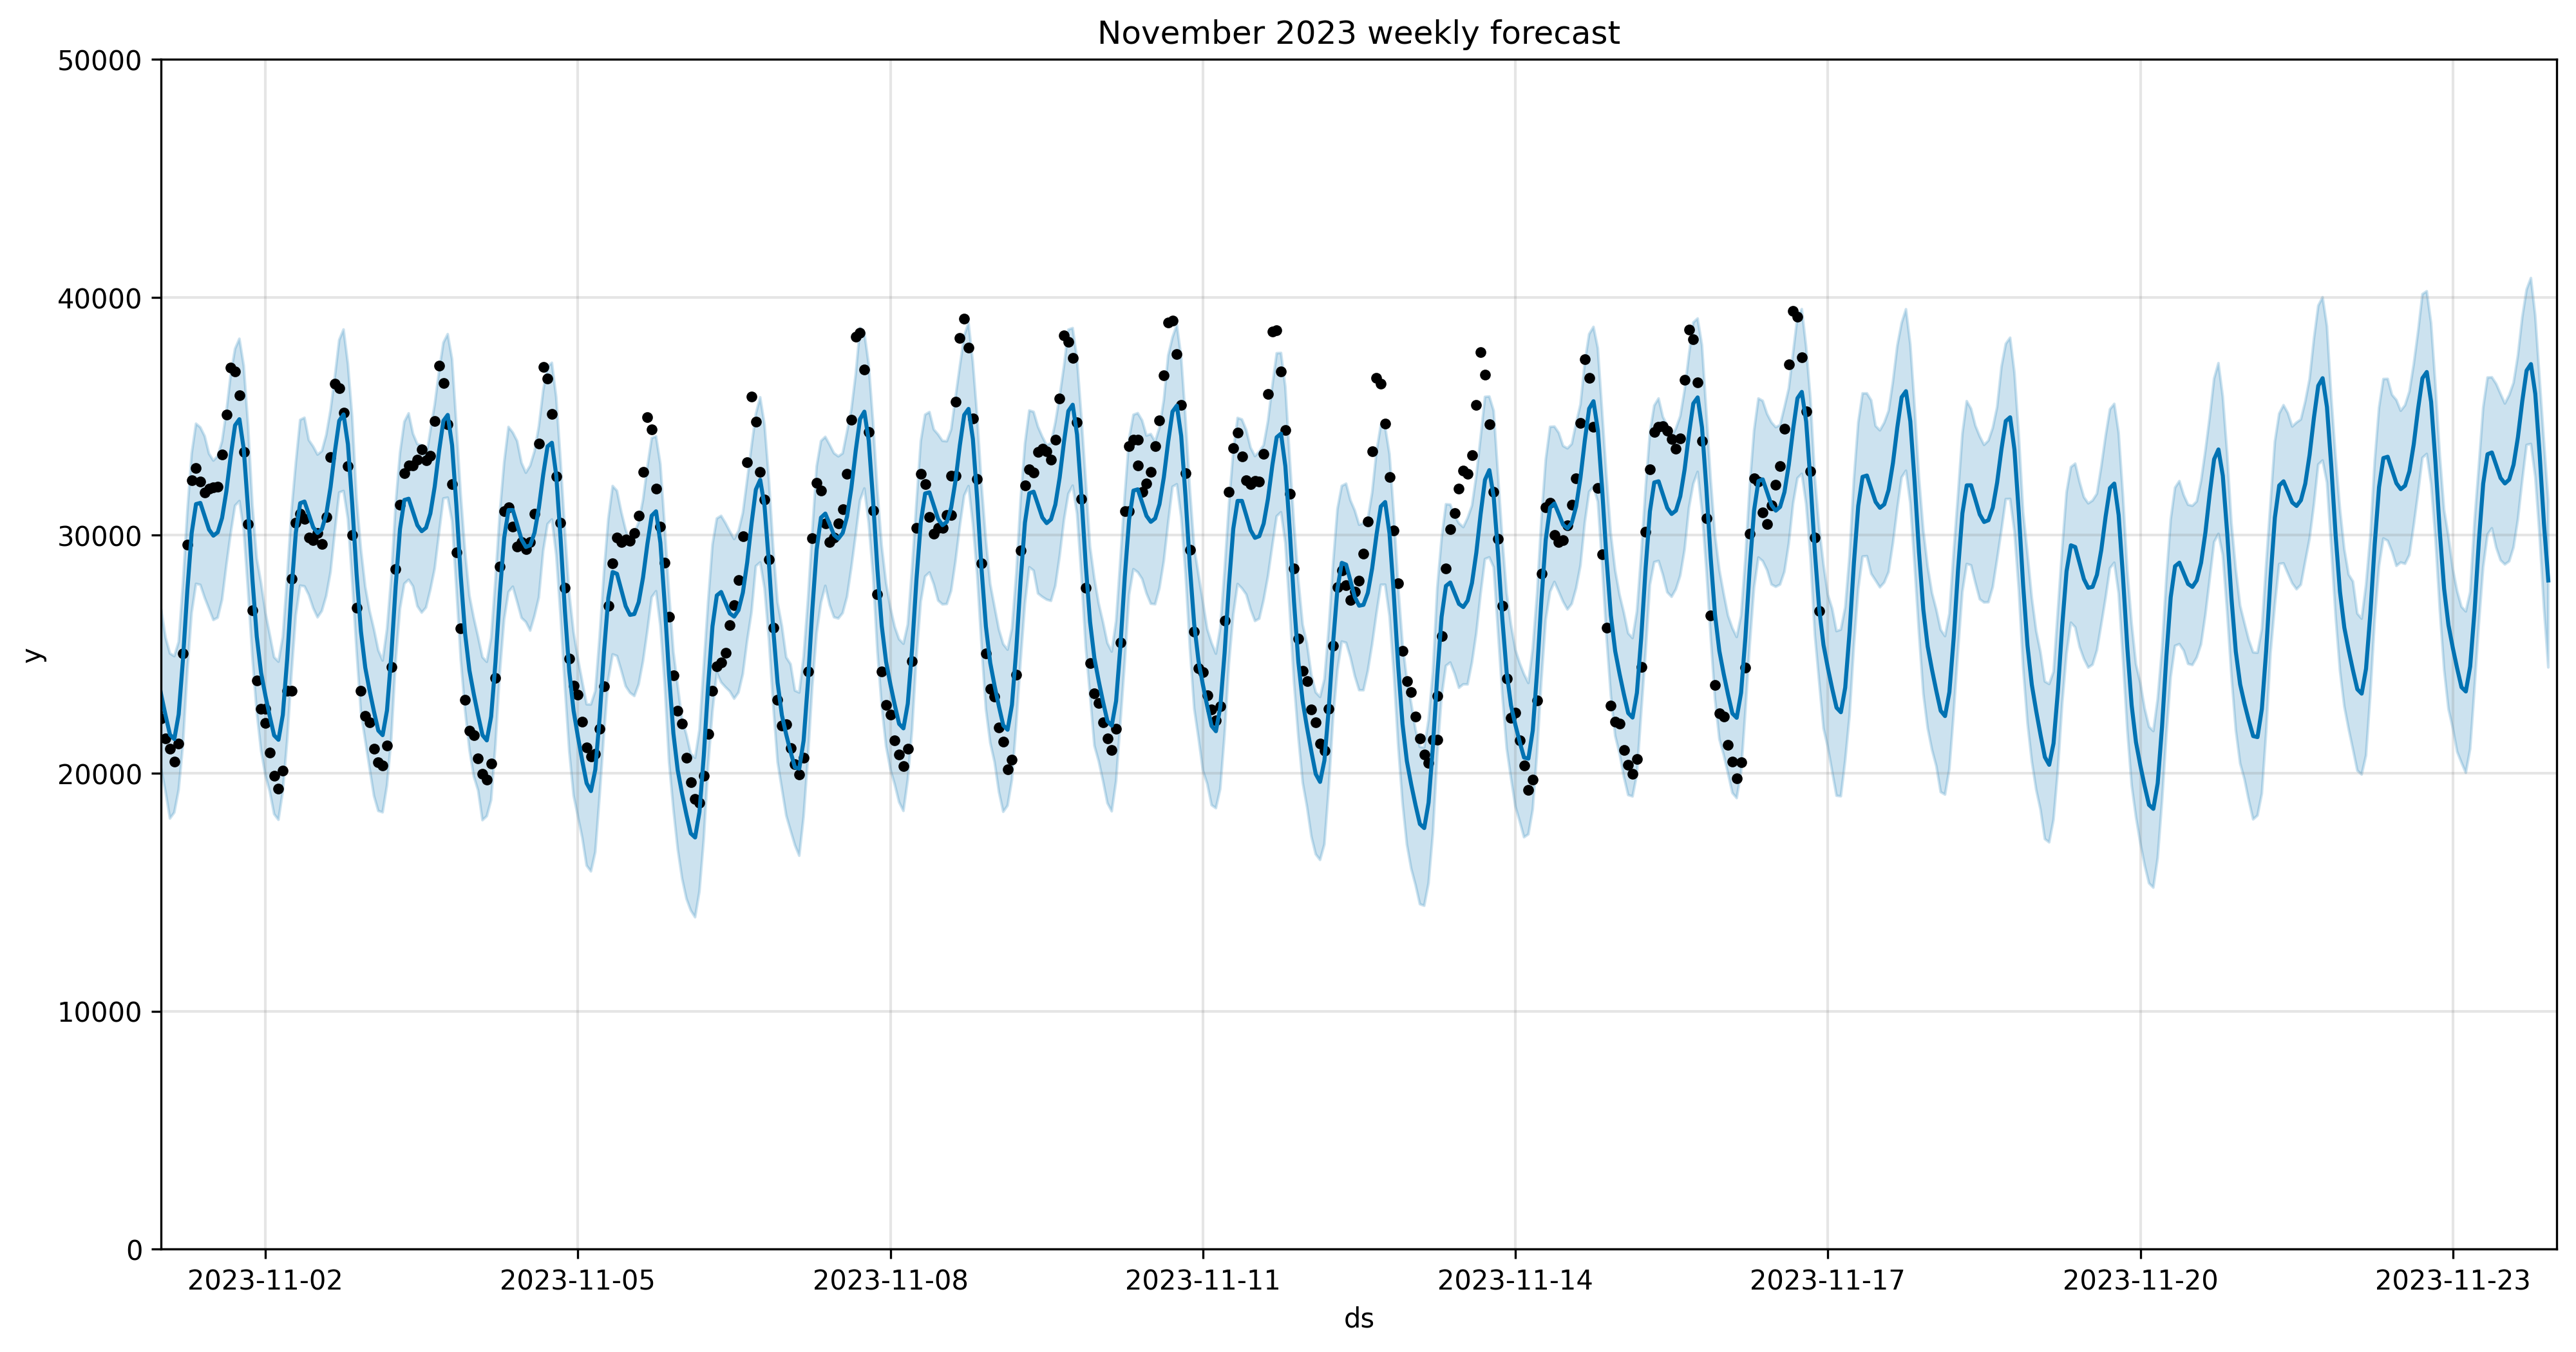

In [39]:
fix, ax = plt.subplots(figsize=(16,8), dpi = 300)

fig = modelpred.plot(forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2023-11-01'), upper=pd.to_datetime('2023-11-24'))
ax.set_ylim(0, 50000)
ax.set_title('November 2023 weekly forecast')